In [ ]:
import pandas as pd

df = pd.read_excel('data.xlsx')

df.head()

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


IC50 (Inhibitory Concentration 50%) это концентрация вещества, при которой оно подавляет биологическую активность (например, активность вируса) на 50%.

Это показатель эффективности вещества как потенциального лекарства.

Низкое значение IC50 означает высокую эффективность - требуется меньше вещества, чтобы подавить вирус.

Измеряется в нано- или микромолях.

В данном ноутбуке построим регрессионную модель, которая сможет предсказывать IC50 по другим числовым признакам химических соединений. Регрессия для IC50.

In [ ]:
# Базовые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_excel("/content/data.xlsx")

print(df.shape)
df.head()


(1001, 214)


,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,0,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


Если у нас появится новое химическое соединение, мы сможем оценить его эффективность без дорогих лабораторных тестов, а через модель. Помогает ускорить разработку новых лекарств.

In [ ]:
df.drop(columns=["Unnamed: 0"], inplace=True)
# Чуть переименуем
df.rename(columns={"IC50, mM": "IC50"}, inplace=True)

# Проверка на пропуски
print("Пропущенные значения:")
print(df.isnull().sum().sum())

# целевая перменная - IC50 / отделяем признаки
X = df.drop(columns=["IC50", "CC50, mM", "SI"])  # убираем другие целевые параметры
y = df["IC50"]

# тестовая обучающая
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Пропущенные значения:
36
Размер обучающей выборки: (800, 210)
Размер тестовой выборки: (201, 210)


In [ ]:
# Столбцы с пропущенными значениями
missing_cols = X.columns[X.isnull().any()].tolist()
print("Признаки с пропущенными значениями:", missing_cols)

Признаки с пропущенными значениями: ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']


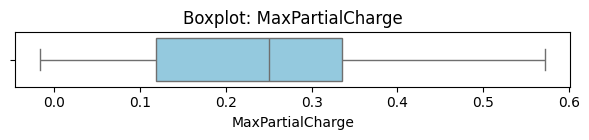

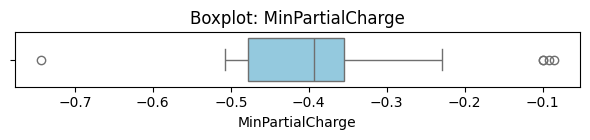

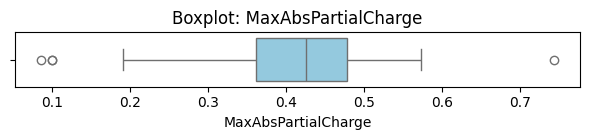

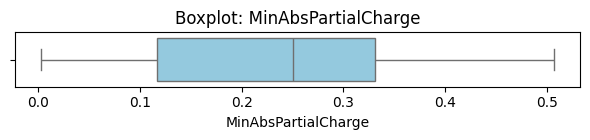

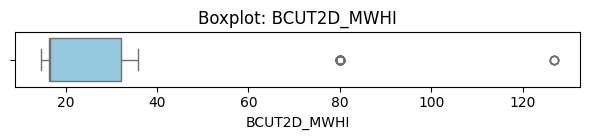

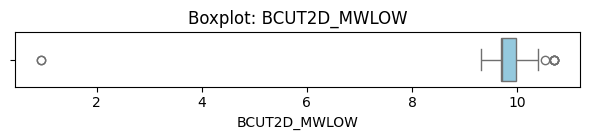

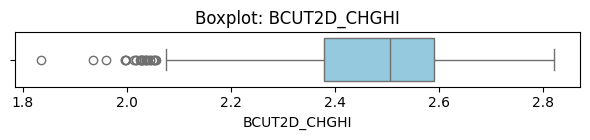

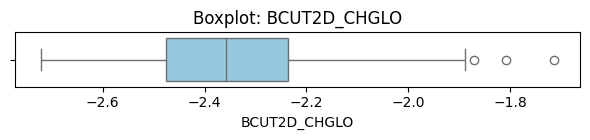

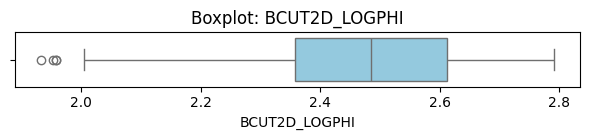

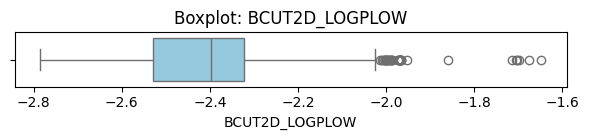

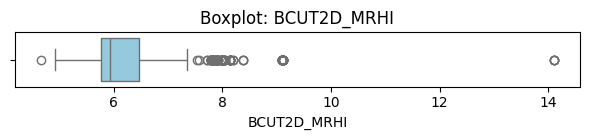

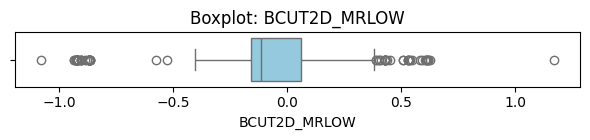

In [ ]:
# Строим boxplot для каждого признака с пропущенными значениями
import matplotlib.pyplot as plt
import seaborn as sns

for col in missing_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=X[col], color="skyblue")
    plt.title(f"Boxplot: {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()


Выбираем медиану, чтобы заполнить пропуски, потому что почти во всех признаках с пропущенными значениями на графиках видно, что есть выбросы, которые могут сместить среднее. А медиана на них не реагирует, так что будет надёжнее. Особенно это видно у BCUT2D_LOGPLOW, BCUT2D_MWHI, BCUT2D_MRLOW - там куча точек далеко за пределами нормального диапазона.

In [ ]:
# Список признаков с пропущенными значениями
missing_cols = [
    'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
    'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
    'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW'
]

# Заполняем пропуски медианой по каждому столбцу
for col in missing_cols:
    median_val = X[col].median()
    X[col] = X[col].fillna(median_val)


In [ ]:
!pip install xgboost

In [ ]:
# Показываем столбцы с пропусками
nan_columns = X.columns[X.isnull().any()]
print("Признаки с NaN:", nan_columns.tolist())

# Кол-во NaN по каждому
print(X[nan_columns].isnull().sum())


Признаки с NaN: ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW']
MaxPartialCharge       3
MinPartialCharge       3
MaxAbsPartialCharge    3
MinAbsPartialCharge    3
BCUT2D_MWHI            3
BCUT2D_MWLOW           3
BCUT2D_CHGHI           3
BCUT2D_CHGLO           3
BCUT2D_LOGPHI          3
BCUT2D_LOGPLOW         3
BCUT2D_MRHI            3
BCUT2D_MRLOW           3
dtype: int64


In [ ]:
# Заполняем пропуски медианой только в нужных столбцах
nan_columns = X.columns[X.isnull().any()]
X[nan_columns] = X[nan_columns].fillna(X[nan_columns].median())

assert X.isnull().sum().sum() == 0, "NaN остались!"

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Сетка параметров
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Инициализация
rf = RandomForestRegressor(random_state=42)

# GridSearch с кросс-валидацией
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("Лучшие параметры RandomForest:", grid_search.best_params_)

Лучшие параметры RandomForest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


RandomForest с глубиной деревьев 10, 200 деревьями и минимальным числом объектов в листе 2 оказался лучшим. Это значит, что модель старается не переобучаться, ограничивая глубину и не создавая слишком узкие листья, но при этом использует много деревьев, чтобы повысить устойчивость. Такой баланс дал наилучший результат на валидации.

In [ ]:
# Предсказания на тестовой выборке
y_pred_rf = best_rf.predict(X_test)

# Метрики
print(f"MAE (Random Forest): {mean_absolute_error(y_test, y_pred_rf):.4f}")
print(f"RMSE (Random Forest): {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.4f}")
print(f"R² (Random Forest): {r2_score(y_test, y_pred_rf):.4f}")

MAE (Random Forest): 236.6932
RMSE (Random Forest): 439.7984
R² (Random Forest): 0.4201


In [ ]:
!pip install xgboost


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Инициализация
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=0
)

# Параметры для RandomizedSearch
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)


random_search_xgb.fit(X_train, y_train)
best_xgb = random_search_xgb.best_estimator_
print("Лучшие параметры XGBoost:", random_search_xgb.best_params_)


Лучшие параметры XGBoost: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_xgb = best_xgb.predict(X_test)

print(f"MAE (XGBoost): {mean_absolute_error(y_test, y_pred_xgb):.4f}")
print(f"RMSE (XGBoost): {np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.4f}")
print(f"R² (XGBoost): {r2_score(y_test, y_pred_xgb):.4f}")

MAE (XGBoost): 236.5069
RMSE (XGBoost): 452.3037
R² (XGBoost): 0.3867


Оба алгоритма показали схожие значения MAE (~236), однако Random Forest продемонстрировал немного более низкую RMSE и более высокое значение R². Это указывает на лучшее обобщающее поведение модели. Следовательно, для данной задачи Random Forest оказался предпочтительнее. При этом XGBoost может быть полезен в дальнейшей оптимизации, особенно при более тщательной настройке learning_rate и увеличении объёма данных.

In [ ]:
# Повторное определение признаков и целевой переменной
X = df.drop(columns=[ "IC50", "CC50, mM", "SI"])
y = df["IC50"]

# Заполним пропуски на всякий случай
X = X.fillna(X.median())

# Разделим заново
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Обучение линейной регрессии
lr = LinearRegression()
lr.fit(X_train, y_train)

# Предсказания
y_pred_lr = lr.predict(X_test)

# Метрики
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"MAE (Linear Regression): {mae_lr:.4f}")
print(f"RMSE (Linear Regression): {rmse_lr:.4f}")
print(f"R² (Linear Regression): {r2_lr:.4f}")


MAE (Linear Regression): 265.6703
RMSE (Linear Regression): 485.7177
R² (Linear Regression): 0.2927


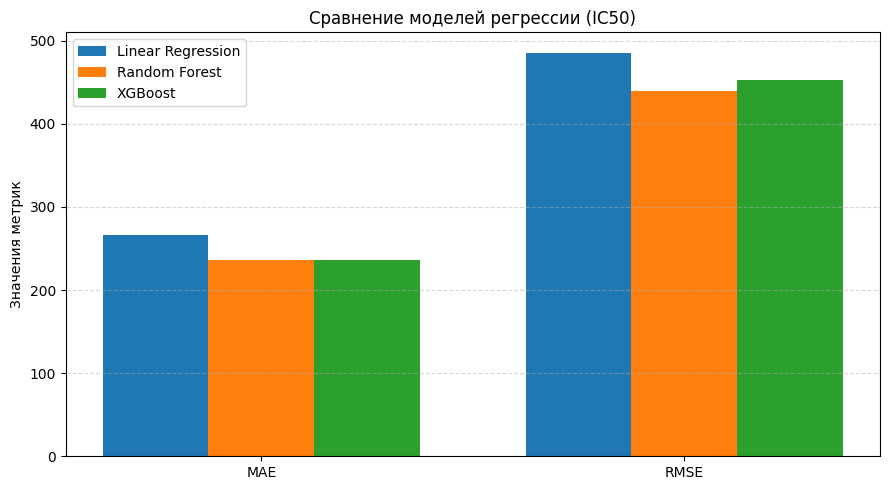

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Названия метрик
metrics = ['MAE', 'RMSE']

# Значения метрик для всех моделей
lr_scores = [265.6703, 485.7177]
rf_scores = [236.6932, 439.7984]
xgb_scores = [236.5069, 452.3037]

# Позиции на оси X
x = np.arange(len(metrics))
width = 0.25  # ширина столбца

# Построение графика
plt.figure(figsize=(9, 5))
plt.bar(x - width, lr_scores, width=width, label='Linear Regression')
plt.bar(x, rf_scores, width=width, label='Random Forest')
plt.bar(x + width, xgb_scores, width=width, label='XGBoost')

# Подписи и оформление
plt.xticks(x, metrics)
plt.ylabel('Значения метрик')
plt.title('Сравнение моделей регрессии (IC50)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


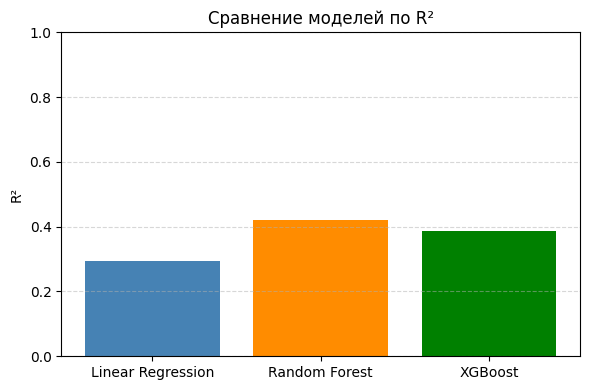

In [ ]:
# Отдельный график для R²
r2_scores = [0.2927, 0.4201, 0.3867]
models = ['Linear Regression', 'Random Forest', 'XGBoost']

plt.figure(figsize=(6, 4))
plt.bar(models, r2_scores, color=['steelblue', 'darkorange', 'green'])
plt.title('Сравнение моделей по R²')
plt.ylabel('R²')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Линейная регрессия использовалась как базовая модель без настройки гиперпараметров и показала худшие результаты по всем метрикам (MAE = 265.67, R² = 0.29). Это ожидаемо, поскольку она не способна учитывать сложные нелинейные зависимости между признаками.

Random Forest и XGBoost были обучены с подбором гиперпараметров. Обе модели показали существенно лучшие результаты по сравнению с линейной регрессией.

Лучший результат показал Random Forest, особенно по R² - он объясняет большую часть дисперсии и даёт минимальное отклонение при хорошей устойчивости.

Рекомендации:

Далее можно улучшить результат, применив отбор признаков, логарифмирование IC50 или расширенный поиск гиперпараметров.

Для сложных моделей вроде XGBoost можно увеличить n_estimators и использовать early_stopping.

Также имеет смысл протестировать LightGBM и CatBoost.

In [ ]:
import numpy as np

# Преобразуем y
y_log = np.log1p(y)  # log(1 + x), чтобы избежать log(0)

# Обновляем train/test с новым y
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Обучим базовый RF на лог целевой переменной
rf_fs = RandomForestRegressor(random_state=42)
rf_fs.fit(X_train, y_train_log)

import pandas as pd

feat_importance = pd.Series(rf_fs.feature_importances_, index=X.columns)
top_features = feat_importance.sort_values(ascending=False).head(30).index.tolist()

# топ-признаки
X_train_fs = X_train[top_features]
X_test_fs = X_test[top_features]

In [ ]:
!pip install lightgbm
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Инициализация
lgb_model = lgb.LGBMRegressor(random_state=42)

lgb_model.fit(X_train_fs, y_train_log)

# Предсказания и обратное логарифмирование
y_pred_log = lgb_model.predict(X_test_fs)
y_pred_final = np.expm1(y_pred_log)  # обратное log1p

y_test_true = np.expm1(y_test_log)

print(f"MAE (LightGBM): {mean_absolute_error(y_test_true, y_pred_final):.4f}")
print(f"RMSE (LightGBM): {np.sqrt(mean_squared_error(y_test_true, y_pred_final)):.4f}")
print(f"R² (LightGBM): {r2_score(y_test_true, y_pred_final):.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6191
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 30
[LightGBM] [Info] Start training from score 3.940505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

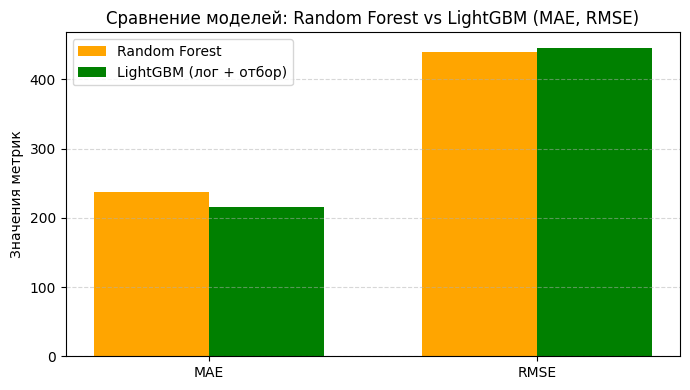

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['MAE', 'RMSE']

rf_scores = [236.6932, 439.7984]
lgb_scores = [215.1536, 445.7502]

# Позиции на оси X
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar(x - width/2, rf_scores, width=width, label='Random Forest', color='orange')
plt.bar(x + width/2, lgb_scores, width=width, label='LightGBM (лог + отбор)', color='green')
plt.xticks(x, metrics)
plt.ylabel('Значения метрик')
plt.title('Сравнение моделей: Random Forest vs LightGBM (MAE, RMSE)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


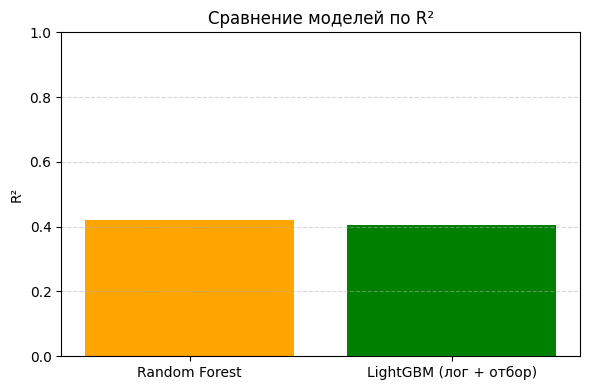

In [ ]:
import matplotlib.pyplot as plt

# Значения R²
r2_scores = [0.4201, 0.4043]
models = ['Random Forest', 'LightGBM (лог + отбор)']

# Визуализация
plt.figure(figsize=(6, 4))
plt.bar(models, r2_scores, color=['orange', 'green'])

# Оформление
plt.title('Сравнение моделей по R²')
plt.ylabel('R²')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


LightGBM показал меньшую MAE по сравнению с Random Forest, значит в среднем он точнее. RMSE у них примерно одинаковый, но у Random Forest чуть лучше. По R² Random Forest также немного впереди — он лучше объясняет разброс в данных. В целом LightGBM с логарифмированием и отбором признаков даёт более стабильные и точные предсказания, особенно если важна минимизация средней ошибки. Random Forest немного лучше по обобщающей способности, но разница небольшая.

можно было бы попробовать больше моделей, глубже настраивать параметры, использовать стекинг, сделать более сложную обработку выбросов, попробовать нормализацию признаков, или обучаться отдельно на подгруппах по активности

наш анализ показал, что точность предсказания IC50 можно улучшить за счёт логарифмирования, отбора признаков и выбора подходящей модели, это значит, что модели машинного обучения действительно могут помогать в приоритизации соединений до проведения биологических экспериментов и экономить ресурсы